In [1]:
from tensorflow.keras.models import load_model
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import normalize
from skimage.io import imread
from skimage.transform import resize
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

from modules.face import FaceDetector

tf.keras.mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  GeForce GTX 1060 6GB, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2021-10-26 00:33:21.872717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 00:33:21.880420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 00:33:21.880907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 00:33:21.881831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
tf.__version__

tf.config.set_visible_devices([], 'GPU')

In [3]:
model_path = os.path.join(os.getcwd(), 'models', 'glint360k_cosface_r100_fp16_0.1.h5')

In [4]:
face_model = load_model(model_path, compile=False)
face_detector = FaceDetector()

2021-10-26 00:33:22.447240: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from skimage import transform

def face_align_landmarks_sk(img, landmarks, image_size=(112, 112), method="similar"):
    tform = transform.AffineTransform() if method == "affine" else transform.SimilarityTransform()
    src = np.array([[38.2946, 51.6963], [73.5318, 51.5014], [56.0252, 71.7366], [41.5493, 92.3655], [70.729904, 92.2041]], dtype=np.float32)
    ret = []
    for landmark in landmarks:
        tform.estimate(landmark, src)
        ret.append(transform.warp(img, tform.inverse, output_shape=image_size))

    return (np.array(ret) * 255).astype(np.uint8)


def do_detect_in_image(image, det, image_format="BGR"):
    imm_BGR = image if image_format == "BGR" else image[:, :, ::-1]
    imm_RGB = image[:, :, ::-1] if image_format == "BGR" else image
    bboxes, pps = det.detect(imm_BGR)
    nimgs = face_align_landmarks_sk(imm_RGB, pps)
    
    return bboxes, nimgs


def prepare_image(img):
    _, img = do_detect_in_image(img, face_detector, image_format="RGB")
    img = ((img - 127.5) * 0.0078125)
    
    return img

def embedding_images(imgs, batch_size=32):
    steps = int(np.ceil(len(imgs) / batch_size))
    embeddings = [face_model(imgs[ii * batch_size : (ii + 1) * batch_size]) for ii in range(steps)]
    embeddings = normalize(np.concatenate(embeddings, axis=0))

    return embeddings

image_classes = ['jolie', 'clark', 'brad']
img1 = imread('jolie.jpg')
img2 = imread('clark.jpeg')
img3 = imread('brad2.jpg')

imgs = [prepare_image(img) for img in [img1, img2, img3]]
imgs = np.concatenate(imgs, axis=0)

embeddings = embedding_images(imgs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Обнаружено лицо: ['brad', 'jolie'] [0.7304988, 0.6778499]


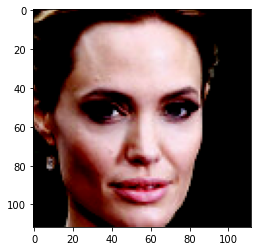

In [11]:
face_threshold = 0.4

test_img = imread('jolie6.jpg')
test_img = prepare_image(test_img)
emb_test = embedding_images([test_img])

dists = np.dot(embeddings, emb_test.T).T
rec_idx = dists.argmax(-1)

rec_dist = [dists[id, ii] for id, ii in enumerate(rec_idx)]
rec_class = [image_classes[ii] for ii in rec_idx]


print(f'Обнаружено лицо: {rec_class} {rec_dist}')


plt.imshow((test_img[1]))